In [2]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sacrebleu import corpus_bleu, corpus_chrf
from sacrebleu.tokenizers import tokenizer_13a, tokenizer_zh
import spacy
import re
from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore")

# Functions

In [306]:
def make_eval_df(
        dataset, hf_path, local_path, 
        hyp_file_un, hyp_file_nbest, hyp_file_al, 
        kiwi_file_un, kiwi_file_nbest, kiwi_file_al, 
        xcomet_file_un, xcomet_file_nbest, xcomet_file_al, 
    ):
    # Load hf dataset
    hf_path_dat = hf_path.format(DATASET=dataset)
    hf_dat = load_dataset(hf_path_dat)['train']
    
    # Load scores and hypotheses files 
    local_path_dat = local_path.format(DATASET=dataset)
    
    # Unaligned model
    with open(f'{local_path_dat}/{hyp_file_un}', 'r') as f:
        hyp_un = [x.replace('\\n', '\n') for x in f.read().split('\n')]
    with open(f'{local_path_dat}/{kiwi_file_un}', 'rb') as f:
        kiwi_un = pickle.load(f)
    with open(f'{local_path_dat}/{xcomet_file_un}', 'rb') as f:
        xcomet_un = pickle.load(f)
    kiwi_xcomet_un = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_un, xcomet_un)]
    
    # N-Best
    with open(f'{local_path_dat}/{hyp_file_nbest}', 'r') as f:
        hyp_nbest = [x.replace('\\n', '\n') for x in f.read().split('\n')]
    with open(f'{local_path_dat}/{kiwi_file_nbest}', 'rb') as f:
        kiwi_nbest = pickle.load(f)
    with open(f'{local_path_dat}/{xcomet_file_nbest}', 'rb') as f:
        xcomet_nbest = pickle.load(f)
    kiwi_xcomet_nbest = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_nbest, xcomet_nbest)]
    
    # Aligned model
    with open(f'{local_path_dat}/{hyp_file_al}', 'r') as f:
        hyp_al = [x.replace('\\n', '\n') for x in f.read().split('\n')]
    with open(f'{local_path_dat}/{kiwi_file_al}', 'rb') as f:
        kiwi_al = pickle.load(f)
    with open(f'{local_path_dat}/{xcomet_file_al}', 'rb') as f:
        xcomet_al = pickle.load(f)
    kiwi_xcomet_al = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_al, xcomet_al)]

    # Fill eval df    
    df = pd.DataFrame()        
    # df['dataset'] = [dataset] * len(hf_dat)
    df['src_lang'] = [lp[:2] for lp in hf_dat['lp']]
    df['tgt_lang'] = [lp[-2:] for lp in hf_dat['lp']]
    df['lp'] = hf_dat['lp']
    df['src'] = hf_dat['src']
    df['ref'] = hf_dat['ref']
    df['mt_un'] = hyp_un
    df['mt_nbest'] = hyp_nbest
    df['mt_al'] = hyp_al
    df['kiwi_un'] = [x * 100 for x in kiwi_un]
    df['kiwi_nbest'] = [x * 100 for x in kiwi_nbest]
    df['kiwi_al'] = [x * 100 for x in kiwi_al]
    df['xcomet_un'] = [x * 100 for x in xcomet_un]
    df['xcomet_nbest'] = [x * 100 for x in xcomet_nbest]
    df['xcomet_al'] = [x * 100 for x in xcomet_al]
    df['kiwi_xcomet_un'] = [x * 100 for x in kiwi_xcomet_un]
    df['kiwi_xcomet_nbest'] = [x * 100 for x in kiwi_xcomet_nbest]
    df['kiwi_xcomet_al'] = [x * 100 for x in kiwi_xcomet_al]

    return df

In [307]:
def compute_bleu(eval_df, systems):
    for system in systems:
        eval_df[f'bleu_{system}'] = [
            corpus_bleu([mt], [[ref]], tokenize='zh').score if tgt_lang == 'zh' else corpus_bleu([mt], [[ref]]).score
            for mt, ref, tgt_lang in zip(eval_df[f'mt_{system}'], eval_df['ref'], eval_df['tgt_lang'])
        ]

In [308]:
def compute_chrf(eval_df, systems):
    for system in systems:
        eval_df[f'chrf_{system}'] = [corpus_chrf([mt], [[ref]]).score for mt, ref in zip(eval_df[f'mt_{system}'], eval_df['ref'])]

In [309]:
def compute_deltas(eval_df, features, base_system, comp_systems):
    for feature in features:
        for system in comp_systems:
            eval_df[f'delta_{feature}_{system}'] = eval_df[f'{feature}_{system}'] - eval_df[f'{feature}_{base_system}']

In [310]:
def do_eval(eval_df, features, lps, comp_systems, display_mode='df'):
    cols = [
        col for col in eval_df.columns 
        if any([f in col for f in features]) and any([s in col for s in comp_systems])
    ]
    cols = [f'{f}_{s}' for f in features for s in comp_systems]
    df = eval_df.loc[np.isin(eval_df.lp, lps), ['src_lang', 'tgt_lang', 'lp'] + cols]
    df_lp = df.groupby('lp')[cols].mean()
    df_lp = df_lp.loc[lps]
    df_lp.loc['xx-en'] = df.loc[df.tgt_lang == 'en', cols].mean()
    df_lp.loc['en-xx'] = df.loc[df.src_lang == 'en', cols].mean()
    df_lp.loc['overall'] = df[cols].mean()
    df_lp.columns = pd.MultiIndex.from_tuples([(f, s) for f in features for s in comp_systems])
    
    if display_mode == 'df':
        return df_lp

    elif display_mode == 'plot':
        plt.figure(figsize=(3.5 * len(features), 2.5))
        for i, feature in enumerate(features):
            plt.subplot(1, len(features), i+1)
            sub_df = df_lp[feature]
            groups = sub_df.index
            values = [sub_df[system] for system in comp_systems]            
            indices = range(len(groups))
            bar_width = 0.35
            for j, vals in enumerate(values):
                plt.bar([idx + j * bar_width for idx in indices], vals, bar_width, label=vals.name)
            plt.xticks([idx + bar_width / 2 for idx in indices], groups, rotation=90)
            xticks_locs, xticks_labels = plt.xticks()
            for j, label in enumerate(xticks_labels):
                if label.get_text() in ['xx-en', 'en-xx', 'overall']:
                    xticks_labels[j].set_fontweight('bold')
            plt.xticks(xticks_locs, xticks_labels)
            plt.ylabel(feature)

        plt.legend()
        plt.subplots_adjust(wspace=0.3)
        plt.show()

In [276]:
def quantify_changes(eval_df, base_system, comp_systems):
    for system in comp_systems:
        eval_df[f'has_changed_{system}'] = eval_df[f'mt_{base_system}'] != eval_df[f'mt_{system}']
        eval_df[f'bleu_un_{system}'] = [
            corpus_bleu([mt1], [[mt2]], tokenize='zh').score if tgt_lang == 'zh' else corpus_bleu([mt1], [[mt2]]).score
            for mt1, mt2, tgt_lang in zip(eval_df[f'mt_{system}'], eval_df[f'mt_{base_system}'], eval_df['tgt_lang'])
        ]   
        eval_df[f'chrf_un_{system}'] = [corpus_chrf([mt1], [[mt2]]).score for mt1, mt2 in zip(eval_df[f'mt_{base_system}'], eval_df[f'mt_{system}'])]

In [277]:
def get_lengths(eval_df, mode, systems):
    if mode == 'char':    
        for system in systems:
            eval_df[f'num_char_{system}'] = [len(mt) for mt in eval_df[f'mt_{system}']]
    
    elif mode == 'word':
        for system in systems:
            eval_df[f'num_words_{system}'] = [
                len(tokenizer_13a.Tokenizer13a()(mt).split()) 
                if mt_lang != 'zh' else len(tokenizer_zh.TokenizerZh()(mt).split()) 
                for mt, mt_lang in zip(eval_df[f'mt_{system}'], eval_df['tgt_lang'])
            ]

In [278]:
def get_aligned_words_from_scores(align_df, threshold):
    aligned_words = set()
    condition = (align_df >= threshold)
    aligned_words = set(condition.stack()[condition.stack()].index.tolist())
    return aligned_words

In [426]:
def get_aligned_words(eval_df, dataset, alw_path, alw_files, threshold):     
    alw_path_dat = alw_path.format(DATASET=dataset)
    
    if isinstance(alw_files, dict):
        alw = alw_files.copy()
        for k, v in alw_files.items():
            with open(f'{alw_path_dat}/{v}', 'rb') as f:
                alw[k] = [x['sys'] for x in pickle.load(f)]
    
    elif isinstance(alw_files, str):
        with open(f'{alw_path_dat}/{alw_files}', 'rb') as f:
            alw = pickle.load(f)
            alw = {k: [x[k] for x in alw] for k in alw[0].keys()}
        
    systems = list(alw.keys()) 
    
    for system in systems:
        eval_df[f'alw_{system}'] = [get_aligned_words_from_scores(align_df, threshold) for align_df in alw[system]]

In [372]:
def assess_word_alignment(eval_df, systems):
    for idx in tqdm(eval_df.index):
        # Process inputs
        if eval_df.loc[idx, 'src_lang'] == 'zh':
            wtok_src = tokenizer_zh.TokenizerZh()
        else:
            wtok_src = tokenizer_13a.Tokenizer13a()
        if eval_df.loc[idx, 'tgt_lang'] == 'zh':
            wtok_mt = tokenizer_zh.TokenizerZh()
        else:
            wtok_mt = tokenizer_13a.Tokenizer13a()
        
        # Get number of words
        num_words_src = len(wtok_src(eval_df.loc[idx, 'src']).strip().split())
        num_words_mt = {system: len(wtok_mt(eval_df.loc[idx, f'mt_{system}']).strip().split()) for system in systems}

        # Compute USW, UTW and TNM
        alw = {system: eval_df.loc[idx, f'alw_{system}'] for system in systems}
        
        try:
            alsw = {system: set(x[0] for x in alw[system]) for system in systems}
            altw = {system: set(x[1] for x in alw[system]) for system in systems}
            eval_df.loc[idx, [f'usw_{system}' for system in systems]] = [
                (1 - len(alsw[system]) / num_words_src) * 100 for system in systems
            ]
            eval_df.loc[idx, [f'utw_{system}' for system in systems]] = [
                (1 - len(altw[system]) / num_words_mt[system]) * 100 for system in systems
            ]
            eval_df.loc[idx, [f'tnm_{system}' for system in systems]] = [
                sum([abs(i / num_words_src - j / num_words_mt[system]) for i, j in alw[system]]) / len(alw[system]) * 100
                for system in systems
            ]
        except:
            pass

In [375]:
# def extract_named_entities(eval_df):
#     nlp = spacy.load("xx_ent_wiki_sm")
#     eval_df['names_ref'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['ref'], desc='References')]
#     eval_df['names_un'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_un'], desc='Unaligned')]
#     eval_df['names_nbest'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_nbest'], desc='N-Best')]
#     eval_df['names_al'] = [set(ent.text for ent in nlp(s).ents) for s in tqdm(eval_df['mt_al'], desc='Aligned')]

In [376]:
# def compute_f1(eval_df, features):
#     for feature in features:
#         # Compute precision
#         eval_df[f'{feature}_P_un'] = [
#             len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_un'])
#         ]
#         eval_df[f'{feature}_P_nbest'] = [
#             len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_nbest'])
#         ]
#         eval_df[f'{feature}_P_al'] = [
#             len(names_ref & names) / len(names) * 100 if len(names) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_al'])
#         ]

#         # Compute recall
#         eval_df[f'{feature}_R_un'] = [
#             len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_un'])
#         ]
#         eval_df[f'{feature}_R_nbest'] = [
#             len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_nbest'])
#         ]
#         eval_df[f'{feature}_R_al'] = [
#             len(names_ref & names) / len(names_ref) * 100 if len(names_ref) > 0 else None 
#             for names_ref, names in zip(eval_df[f'{feature}_ref'], eval_df[f'{feature}_al'])
#         ]

#         # Compute F1
#         eval_df[f'{feature}_F1_un'] = 2 / (1 / eval_df[f'{feature}_P_un'] + 1 / eval_df[f'{feature}_R_un'])
#         eval_df[f'{feature}_F1_nbest'] = 2 / (1 / eval_df[f'{feature}_P_nbest'] + 1 / eval_df[f'{feature}_R_nbest'])
#         eval_df[f'{feature}_F1_al'] = 2 / (1 / eval_df[f'{feature}_P_al'] + 1 / eval_df[f'{feature}_R_al'])

In [377]:
# def extract_numbers(eval_df):
#     eval_df['numbers_ref'] = [set(re.findall( r'\d+', s)) for s in eval_df['ref']]
#     eval_df['numbers_un'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_un']]
#     eval_df['numbers_nbest'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_nbest']]
#     eval_df['numbers_al'] = [set(re.findall( r'\d+', s)) for s in eval_df['mt_al']]

In [378]:
# def count_punct_symbols(eval_df, punct_symbols):
#     eval_df['num_punct_un'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_un']]
#     eval_df['num_punct_nbest'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_nbest']]
#     eval_df['num_punct_al'] = [len([char for char in mt if char in punct_symbols]) for mt in eval_df['mt_al']]

In [288]:
def print_string(string, lang, max_words_per_line):
    # Tokenize text
    if lang == 'zh':
        string_tok = tokenizer_zh.TokenizerZh()(string).split()
    else:
        string_tok = tokenizer_13a.Tokenizer13a()(string).split()
    num_lines = int(np.ceil(len(string_tok) / max_words_per_line))
    
    # Print with max_words_per_line
    string_pr = []
    for i in range(num_lines):
        string_pr.append(' '.join(string_tok[i * max_words_per_line : (i+1) * max_words_per_line]))
    string_pr = '\n'.join(string_pr)
    print(string_pr)

In [289]:
def extract_examples_gen(
        eval_df, 
        ppty='num_words', 
        tgt_lang='en', 
        min_delta_xcomet=1, 
        max_delta_delta_xcomet=1,
        min_abs_delta_ppty=5, 
        trend='increase', 
        num_ex=3
):
    df_ex = eval_df[eval_df.tgt_lang == tgt_lang] # Filter given ref lang
    df_ex = df_ex[df_ex.delta_xcomet_al >= min_delta_xcomet] # Filter by minimum xcomet imporvement
    df_ex = df_ex[abs(df_ex.delta_xcomet_al - df_ex.delta_xcomet_nbest) <= max_delta_delta_xcomet] # Filter only close engough nbest and al translations wrt xcomet improvement
    if trend == 'decrease':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] <= -min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()]
    elif trend == 'increase':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] >= min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()[::-1]]

    for i in range(num_ex):
        print('**********')
        print(f'Example {i+1}:')
        print('**********\n')
        print(df_ex.iloc[[i]][['lp', 'xcomet_un', 'xcomet_nbest', 'xcomet_al', f'{ppty}_un', f'{ppty}_nbest', f'{ppty}_al', f'delta_{ppty}_nbest', f'delta_{ppty}_al']].to_string(index=False))
        print('')
        print('===> src:')
        print_string(df_ex.iloc[i]['src'], tgt_lang, 20)
        print('')
        print('===> ref:')
        print_string(df_ex.iloc[i]['ref'], tgt_lang, 20)
        print('')
        print('===> mt_un:')
        print_string(df_ex.iloc[i]['mt_un'], tgt_lang, 20)
        print('')
        print('===> mt_nbest:')
        print_string(df_ex.iloc[i]['mt_nbest'], tgt_lang, 20)
        print('')
        print('===> mt_al:')
        print_string(df_ex.iloc[i]['mt_al'], tgt_lang, 20)
        print('')

In [290]:
def print_unaligned_words(src, mt, lp, alw, ppty):
    src_lang, tgt_lang = lp.split('-')
    
    if ppty == 'usw':
        if src_lang == 'zh':
            sent_wtok = tokenizer_zh.TokenizerZh()(src).strip().split()
        else:
            sent_wtok = tokenizer_13a.Tokenizer13a()(src).strip().split()
        alw_set = set(x[0] for x in alw)
    
    elif ppty == 'utw':
        if tgt_lang == 'zh':
            sent_wtok = tokenizer_zh.TokenizerZh()(mt).strip().split()
        else:
            sent_wtok = tokenizer_13a.Tokenizer13a()(mt).strip().split()
        alw_set = set(x[1] for x in alw)

    RED = "\033[31m"
    BOLD = "\033[1m"
    RESET = "\033[0m"
    s = ''
    for j, w in enumerate(sent_wtok):
        if j in alw_set:
            s += f'{w} '
        else:
            s += f'{RED}{BOLD}{w}{RESET} '
    print(s)

In [291]:
def extract_examples_alw(
        eval_df,
        ppty,
        tgt_lang='de',
        min_num_char=50,
        min_delta_xcomet=1,
        max_delta_delta_xcomet=1,
        min_abs_delta_ppty=5, 
        trend='increase', 
        num_ex=3
):
    df_ex = eval_df.copy()
    df_ex = df_ex[df_ex.tgt_lang == tgt_lang]
    df_ex = df_ex[df_ex.num_char_un >= min_num_char]
    df_ex = df_ex[df_ex.delta_xcomet_al >= min_delta_xcomet]
    df_ex = df_ex[abs(df_ex.delta_xcomet_al - df_ex.delta_xcomet_nbest) <= max_delta_delta_xcomet]
    if trend == 'decrease':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] <= -min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()]
    elif trend == 'increase':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] >= min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()[::-1]]

    for i in range(num_ex):        
        print('**********')
        print(f'Example {i+1}:')
        print('**********\n')
        print(df_ex.iloc[[i]][['lp', 'xcomet_un', 'xcomet_nbest', 'xcomet_al', f'{ppty}_un', f'{ppty}_nbest', f'{ppty}_al', f'delta_{ppty}_nbest', f'delta_{ppty}_al']].to_string(index=False))
        print('')

        if ppty == 'utw':
            print('===> src:')
            print(df_ex.iloc[i]['src'])
            print('')
            for sfx in ['un', 'nbest', 'al']:
                print(f'===> mt_{sfx}:')
                print_unaligned_words(df_ex.iloc[i]['src'], df_ex.iloc[i][f'mt_{sfx}'], df_ex.iloc[i]['lp'], df_ex.iloc[i][f'alw_{sfx}'], ppty)
                print('')

        elif ppty == 'usw':
            for sfx in ['un', 'nbest', 'al']:
                print(f'===> mt_{sfx}:')
                print('=> mt:')
                print(df_ex.iloc[i][f'mt_{sfx}'])
                print('=> src:')
                print_unaligned_words(df_ex.iloc[i]['src'], df_ex.iloc[i][f'mt_{sfx}'], df_ex.iloc[i]['lp'], df_ex.iloc[i][f'alw_{sfx}'], ppty)
                print('')

In [292]:
def get_alw_df(src, mt, lp, alw):
    src_lang, tgt_lang = lp.split('-')

    if src_lang == 'zh':
        src_wtok = tokenizer_zh.TokenizerZh()(src).strip().split()
    else:
        src_wtok = tokenizer_13a.Tokenizer13a()(src).strip().split()
    if tgt_lang == 'zh':
        mt_wtok = tokenizer_zh.TokenizerZh()(mt).strip().split()
    else:
        mt_wtok = tokenizer_13a.Tokenizer13a()(mt).strip().split()

    alw_df = pd.DataFrame(0, index=src_wtok, columns=mt_wtok)
    for i, j in alw:
        alw_df.iloc[i,j] = 1

    return alw_df

In [293]:
def extract_examples_tnm(
        eval_df,
        ppty='tnm',
        min_num_char=50,
        max_tnm_un=10,
        min_delta_xcomet=1,
        max_delta_delta_xcomet=1,
        min_abs_delta_ppty=5,
        trend='increase',
        num_ex=3
):
    df_ex = eval_df.copy()
    df_ex = df_ex[df_ex.num_char_un >= min_num_char]
    df_ex = df_ex[df_ex.tnm_un <= max_tnm_un]
    df_ex = df_ex[df_ex.delta_xcomet_al >= min_delta_xcomet]
    df_ex = df_ex[abs(df_ex.delta_xcomet_al - df_ex.delta_xcomet_nbest) <= max_delta_delta_xcomet]
    if trend == 'decrease':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] <= -min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()]
    elif trend == 'increase':
        df_ex = df_ex[df_ex[f'delta_{ppty}_al'] >= min_abs_delta_ppty].reset_index(drop=True)
        df_ex = df_ex.loc[(df_ex[f'delta_{ppty}_al'] - df_ex[f'delta_{ppty}_nbest']).values.argsort()[::-1]]

    for i in range(num_ex):
        alw_un_df = get_alw_df(df_ex.iloc[i]['src'], df_ex.iloc[i]['mt_un'], df_ex.iloc[i]['lp'], df_ex.iloc[i]['alw_un'])
        alw_nbest_df = get_alw_df(df_ex.iloc[i]['src'], df_ex.iloc[i]['mt_nbest'], df_ex.iloc[i]['lp'], df_ex.iloc[i]['alw_nbest'])
        alw_al_df = get_alw_df(df_ex.iloc[i]['src'], df_ex.iloc[i]['mt_al'], df_ex.iloc[i]['lp'], df_ex.iloc[i]['alw_al'])
        print('**********')
        print(f'Example {i+1}:')
        print('**********\n')
        print(df_ex.iloc[[i]][['lp', 'xcomet_un', 'xcomet_nbest', 'xcomet_al', f'{ppty}_un', f'{ppty}_nbest', f'{ppty}_al', f'delta_{ppty}_nbest', f'delta_{ppty}_al']].to_string(index=False))     
        plt.figure(figsize=(12,3))
        plt.subplot(1,3,1)
        sns.heatmap(alw_un_df, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
        plt.title('un')
        plt.subplot(1,3,2)
        sns.heatmap(alw_nbest_df, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
        plt.yticks([])
        plt.title('nbest')
        plt.subplot(1,3,3)
        sns.heatmap(alw_al_df, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
        plt.yticks([])
        plt.title('al')
        plt.show()

# Set-up

In [311]:
# Make evaluation dataset with xcomet scores
hf_path = 'hgissbkh/{DATASET}'
local_path = '../data/evaluation/{DATASET}'
dataset = 'wmt22-23-test'
hyp_file_un = 'ALMA-13B-LoRA-Pre-CPO/hypotheses_greedy.txt'
xcomet_file_un = 'ALMA-13B-LoRA-Pre-CPO/xcomet_greedy.pkl'
kiwi_file_un = 'ALMA-13B-LoRA-Pre-CPO/kiwi_greedy.pkl'
hyp_file_nbest = 'ALMA-13B-LoRA-Pre-CPO/hypotheses_nbest_N5_t0.4_p0.6.txt'
xcomet_file_nbest = 'ALMA-13B-LoRA-Pre-CPO/xcomet_nbest_N5_t0.4_p0.6.pkl'
kiwi_file_nbest = 'ALMA-13B-LoRA-Pre-CPO/kiwi_nbest_N5_t0.4_p0.6.pkl'
hyp_file_al = 'ALMA-13B-R/hypotheses_greedy.txt'
xcomet_file_al = 'ALMA-13B-R/xcomet_greedy.pkl'
kiwi_file_al = 'ALMA-13B-R/kiwi_greedy.pkl'
eval_df = make_eval_df(
        dataset, hf_path, local_path, 
        hyp_file_un, hyp_file_nbest, hyp_file_al, 
        kiwi_file_un, kiwi_file_nbest, kiwi_file_al, 
        xcomet_file_un, xcomet_file_nbest, xcomet_file_al, 
)

# Motivations

In [429]:
# Init systems
base_system = 'un'
comp_systems = ['nbest', 'al']
systems = [base_system] + comp_systems

In [314]:
# Compute lexical metrics and deltas
compute_bleu(eval_df, systems)
compute_chrf(eval_df, systems)
compute_deltas(eval_df, ['kiwi', 'xcomet', 'kiwi_xcomet', 'bleu', 'chrf'], base_system, comp_systems)

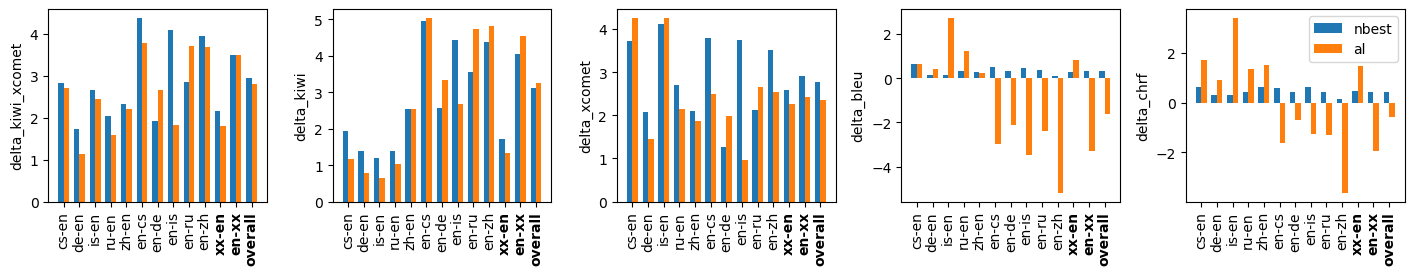

delta_kiwi_xcomet           delta_kiwi           delta_xcomet  \
                    nbest        al      nbest        al        nbest   
lp                                                                      
cs-en            2.832999  2.709066   1.941006  1.167799     3.724991   
de-en            1.734738  1.126285   1.382854  0.794785     2.086621   
is-en            2.647170  2.440637   1.184961  0.637695     4.109379   
ru-en            2.036791  1.594090   1.372404  1.038876     2.701178   
zh-en            2.319187  2.199481   2.541833  2.525426     2.096540   
en-cs            4.364382  3.763389   4.945738  5.028498     3.783025   
en-de            1.910216  2.654161   2.563887  3.325659     1.256544   
en-is            4.083992  1.810151   4.419751  2.665234     3.748233   
en-ru            2.837296  3.693077   3.551436  4.723594     2.123156   
en-zh            3.947405  3.672890   4.384777  4.803065     3.510033   
xx-en            2.150749  1.795090   1.708767  1.339286     2.592730   
en-xx            3.481906  3.479630   4.059431  4.543646     2.904382   
overall          2.944104  2.799058   3.109738  3.249050     2.778471   

                  delta_bleu           delta_chrf            
               al      nbest        al      nbest        al  
lp                                                           
cs-en    4.250333   0.630636  0.651860   0.623958  1.693941  
de-en    1.457785   0.119222  0.422028   0.287354  0.913589  
is-en    4.243580   0.132711  2.724922   0.290106  3.405885  
ru-en    2.149304   0.341058  1.234136   0.429841  1.340302  
zh-en    1.873535   0.267114  0.227536   0.616058  1.511640  
en-cs    2.498281   0.480593 -2.970636   0.599631 -1.612082  
en-de    1.982663   0.325817 -2.102688   0.440778 -0.712370  
en-is    0.955067   0.464020 -3.474605   0.645026 -1.264456  
en-ru    2.662561   0.360730 -2.379450   0.416087 -1.319202  
en-zh    2.542714   0.109433 -5.187642   0.156393 -3.619813  
xx-en    2.250894   0.283932  0.832789   0.452002  1.449974  
en-xx    2.415614   0.324632 -3.315248   0.408853 -1.939032  
overall  2.349065   0.308189 -1.639397   0.426286 -0.569837

In [315]:
# Display results
lps = [
    'cs-en', 
    'de-en', 
    'is-en', 
    'ru-en', 
    'zh-en', 
    'en-cs', 
    'en-de',
    'en-is', 
    'en-ru', 
    'en-zh'
]
features = ['delta_kiwi_xcomet', 'delta_kiwi', 'delta_xcomet', 'delta_bleu', 'delta_chrf']
do_eval(eval_df, features, lps, comp_systems, display_mode='plot')
do_eval(eval_df, features, lps, comp_systems, display_mode='df')

In [316]:
# Quantify translation changes (nbest vs. al)
quantify_changes(eval_df, base_system, comp_systems)

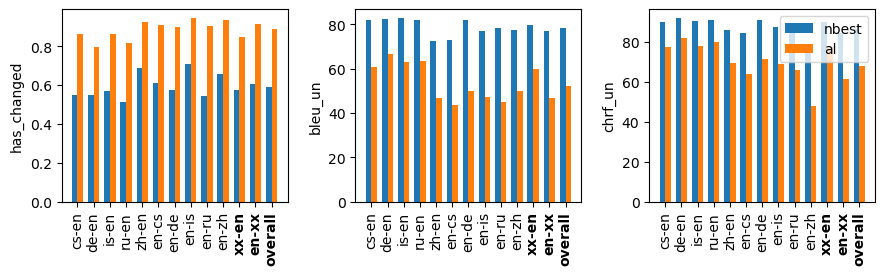

has_changed              bleu_un               chrf_un           
              nbest        al      nbest         al      nbest         al
lp                                                                       
cs-en      0.549033  0.863260  82.102902  60.862917  90.142352  77.439774
de-en      0.550262  0.794272  82.376672  66.460339  91.877829  82.201576
is-en      0.570000  0.863000  82.764455  63.016448  90.317247  77.849193
ru-en      0.514830  0.814537  82.019942  63.245767  90.944655  80.032164
zh-en      0.686575  0.923397  72.684224  46.797631  86.207023  69.475039
en-cs      0.608084  0.909620  73.037835  43.363640  84.434697  63.684235
en-de      0.574103  0.896858  81.821498  50.077702  90.917622  71.311001
en-is      0.710000  0.944000  76.926159  47.065569  87.286792  68.984870
en-ru      0.543250  0.902668  78.406155  45.104616  88.373909  65.745507
en-zh      0.655618  0.936459  77.577931  49.832953  76.666507  47.761251
xx-en      0.572960  0.844725  79.824521  59.649786  89.863223  77.516890
en-xx      0.603145  0.914780  77.127027  46.694855  84.416973  61.200217
overall    0.590950  0.886477  78.216844  51.928786  86.617316  67.792328

In [317]:
# Display results
do_eval(eval_df, ['has_changed', 'bleu_un', 'chrf_un'], lps, comp_systems, display_mode='plot')
do_eval(eval_df, ['has_changed', 'bleu_un', 'chrf_un'], lps, comp_systems, display_mode='df')

# Analysis

We only consider changed translations with high enough XCOMET

## Test dataset

wmt22-23-test

In [318]:
# Filter out changed translations only
# min_xcomet = 80
# eval_df = eval_df.loc[
#     (eval_df.has_changed_nbest == True) & (eval_df.has_changed_al == True)
#     & (eval_df.xcomet_nbest >= min_xcomet) & (eval_df.xcomet_al >= min_xcomet)
# ]

### Translation length

Takeway: translations generated using the aligned model are more verbose than those generated using N-Best.

In [319]:
get_lengths(eval_df, 'char', systems)
get_lengths(eval_df, 'word', systems)
compute_deltas(eval_df, ['num_char', 'num_words'], base_system, comp_systems)

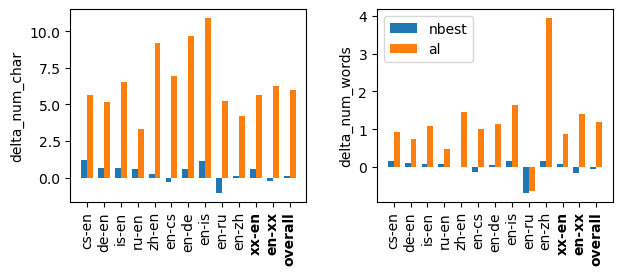

delta_num_char            delta_num_words          
                 nbest         al           nbest        al
lp                                                         
cs-en         1.194061   5.614641        0.160912  0.931630
de-en         0.666758   5.164418        0.118700  0.741944
is-en         0.639000   6.511000        0.091000  1.088000
ru-en         0.623215   3.285244        0.085683  0.474551
zh-en         0.217865   9.183329       -0.001818  1.445079
en-cs        -0.298626   6.923040       -0.133549  0.996120
en-de         0.565217   9.686449        0.056490  1.147890
en-is         1.169000  10.906000        0.166000  1.643000
en-ru        -1.032660   5.207922       -0.681811 -0.625061
en-zh         0.137753   4.174293        0.163945  3.948585
xx-en         0.586798   5.632926        0.079002  0.863306
en-xx        -0.195191   6.266009       -0.162292  1.408306
overall       0.120741   6.010237       -0.064807  1.188120

In [320]:
do_eval(eval_df, ['delta_num_char', 'delta_num_words'], lps, comp_systems, display_mode='plot')
do_eval(eval_df, ['delta_num_char', 'delta_num_words'], lps, comp_systems, display_mode='df')

In [321]:
# extract_examples_gen(eval_df, 'num_words')

### Word alignment (USW, UTW, TNM)

Takeways:
* Overall, translations generated with the aligned model are less literal (increased UTW and TNM)
* However, they show decreased USW. This might come from the fact, as CPO translations are more verbose, there are more candidates to get aligned with source words.
* Difference xx-en vs. en-xx

In [427]:
dataset = 'wmt22-23-test'
alw_path = '../data/evaluation/{DATASET}'
alw_files = {
    'un': 'ALMA-13B-LoRA-Pre-CPO/aligned_words_greedy.pkl',
    'nbest': 'ALMA-13B-LoRA-Pre-CPO/aligned_words_nbest_N5_t0.4_p0.6.pkl',
    'al': 'ALMA-13B-R/aligned_words_greedy.pkl'
}
threshold = 350
get_aligned_words(eval_df, dataset, alw_path, alw_files, threshold)

In [430]:
assess_word_alignment(eval_df, systems)
compute_deltas(eval_df, ['usw', 'utw', 'tnm'], base_system, comp_systems)

100%|██████████| 38098/38098 [00:40<00:00, 945.24it/s] 


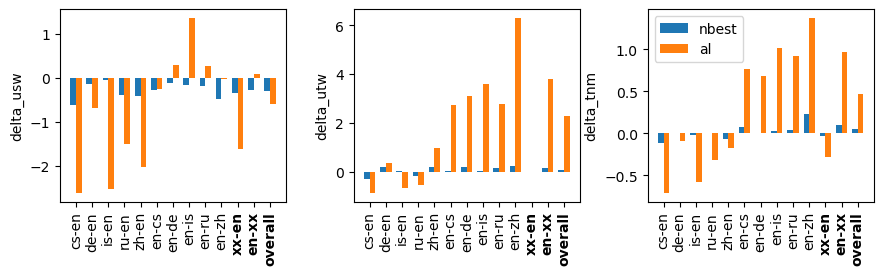

delta_usw           delta_utw           delta_tnm          
            nbest        al     nbest        al     nbest        al
lp                                                                 
cs-en   -0.613635 -2.608019 -0.317927 -0.871169 -0.112219 -0.706645
de-en   -0.142850 -0.692715  0.169755  0.341506  0.002619 -0.094328
is-en   -0.053607 -2.532562  0.033509 -0.688496 -0.025627 -0.579298
ru-en   -0.398549 -1.495505 -0.163266 -0.569997  0.003633 -0.322767
zh-en   -0.409936 -2.032128  0.166343  0.943198 -0.067845 -0.174195
en-cs   -0.276222 -0.255473  0.034074  2.709197  0.081054  0.767299
en-de   -0.106691  0.302876  0.170483  3.085450  0.005412  0.681184
en-is   -0.172037  1.364683  0.010490  3.566778  0.033275  1.009842
en-ru   -0.177325  0.264921  0.142331  2.772116  0.038314  0.916875
en-zh   -0.478230 -0.034188  0.234801  6.299103  0.228472  1.373751
xx-en   -0.338902 -1.612422 -0.004071 -0.012782 -0.027240 -0.284686
en-xx   -0.276194  0.095395  0.136131  3.794191  0.096919  0.971878
overall -0.301529 -0.594581  0.079501  2.256491  0.046779  0.464434

In [431]:
do_eval(eval_df, ['delta_usw', 'delta_utw', 'delta_tnm'], lps, comp_systems, display_mode='plot')
do_eval(eval_df, ['delta_usw', 'delta_utw', 'delta_tnm'], lps, comp_systems, display_mode='df')

In [379]:
# df_ex = extract_examples_alw(eval_df, ppty='usw', tgt_lang='en', trend='decrease')

In [380]:
# extract_examples_alw(eval_df, ppty='utw', tgt_lang='de', trend='increase')

In [381]:
# extract_examples_tnm(eval_df)

## Train dataset (ALMA-R-Preference)

Do the aligned model (post-CPO) only reproduce the properties observed in the chosen sentences of the preference dataset?

In [437]:
base_system = 'alma'
comp_systems = ['rejected', 'chosen']
systems = [base_system] + comp_systems

In [438]:
# Load preference data
lps = ['cs-en', 'de-en', 'is-en', 'ru-en', 'zh-en']
pref_data = pd.DataFrame()
row = 0

for lp in lps:
    dataset_lp = load_dataset('haoranxu/ALMA-R-Preference', lp)['train']['translation']
    lang1, lang2 = lp.split('-')
    pairs = [(lang1, lang2), (lang2, lang1)]

    for ex in tqdm(dataset_lp, desc=lp):        
        for src_lang, tgt_lang in pairs:
            pref_data.loc[row, 'lp'] = f'{src_lang}-{tgt_lang}'
            pref_data.loc[row, 'src_lang'] = src_lang
            pref_data.loc[row, 'tgt_lang'] = tgt_lang
            pref_data.loc[row, 'src'] = ex[src_lang]

            if 'Delta' in ex and ex['Delta'] != 0:
                if ex['Delta'] > 0:
                    chosen_sys, rejected_sys = 'gpt4', 'alma'
                else:
                    chosen_sys, rejected_sys = 'alma', 'gpt4'
            else:
                cdts_dict = {'alma': ex[f'alma_{tgt_lang}_kiwi_xcomet'], 'gpt4': ex[f'gpt4_{tgt_lang}_kiwi_xcomet'], 'ref': ex[f'ref_{tgt_lang}_kiwi_xcomet']}
                chosen_sys = max(cdts_dict, key=cdts_dict.get)
                rejected_sys = min(cdts_dict, key=cdts_dict.get)
            
            pref_data.loc[row, 'mt_alma'] = ex[f'alma_{tgt_lang}']  
            pref_data.loc[row, 'mt_rejected'] = ex[f'{rejected_sys}_'*(rejected_sys!='ref') + tgt_lang]
            pref_data.loc[row, 'mt_chosen'] = ex[f'{chosen_sys}_'*(chosen_sys!='ref') + tgt_lang]

            pref_data.loc[row, 'sys_rejected'] = rejected_sys
            pref_data.loc[row, 'sys_chosen'] = chosen_sys

            pref_data.loc[row, 'kiwi_xcomet_alma'] = ex[f'alma_{tgt_lang}_kiwi_xcomet']
            pref_data.loc[row, 'kiwi_xcomet_rejected'] = ex[f'{rejected_sys}_{tgt_lang}_kiwi_xcomet']
            pref_data.loc[row, 'kiwi_xcomet_chosen'] = ex[f'{chosen_sys}_{tgt_lang}_kiwi_xcomet']
            
            row += 1

zh-en: 100%|██████████| 3065/3065 [00:29<00:00, 103.45it/s]


### Translation length

In [439]:
lps = ['cs-en', 'de-en', 'is-en', 'ru-en', 'zh-en', 'en-cs', 'en-de','en-is', 'en-ru', 'en-zh']

In [440]:
get_lengths(pref_data, 'char', systems)
get_lengths(pref_data, 'word', systems)
compute_deltas(pref_data, ['num_char', 'num_words'], base_system, comp_systems)

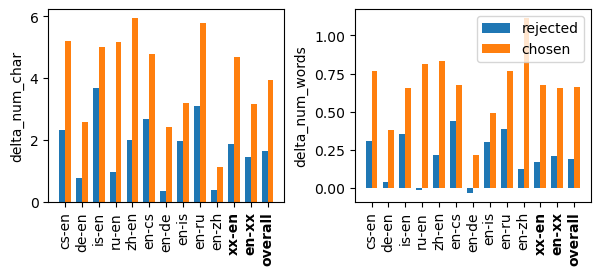

delta_num_char           delta_num_words          
              rejected    chosen        rejected    chosen
lp                                                        
cs-en         2.300647  5.211050        0.305127  0.766053
de-en         0.770962  2.575204        0.037194  0.380424
is-en         3.690891  4.988552        0.354903  0.656048
ru-en         0.962170  5.168741       -0.014933  0.811349
zh-en         2.002284  5.936705        0.214356  0.829038
en-cs         2.687904  4.791439        0.436038  0.671478
en-de         0.331158  2.404568       -0.034258  0.213703
en-is         1.957690  3.193131        0.297163  0.488303
en-ru         3.098556  5.792932        0.383275  0.764559
en-zh         0.369657  1.114519        0.123002  1.116476
xx-en         1.848318  4.685695        0.170025  0.674015
en-xx         1.456445  3.164021        0.206877  0.653368
overall       1.652381  3.924858        0.188451  0.663692

In [441]:
do_eval(pref_data, ['delta_num_char', 'delta_num_words'], lps, comp_systems, display_mode='plot')
do_eval(pref_data, ['delta_num_char', 'delta_num_words'], lps, comp_systems, display_mode='df')

### Word alignment (USW, UTW, TNM)

In [442]:
dataset = 'ALMA-R-Preference'
alw_path = '../data/training/{DATASET}'
alw_files = 'ALMA-13B-LoRA-Pre-CPO/aligned_words_greedy.pkl'
threshold = 350
get_aligned_words(pref_data, dataset, alw_path, alw_files, threshold)

In [443]:
### TODO: fix function
pref_data['alw_rejected'] = [pref_data.loc[idx, f'alw_{pref_data.loc[idx, "sys_rejected"]}'] for idx in pref_data.index]
pref_data['alw_chosen'] = [pref_data.loc[idx, f'alw_{pref_data.loc[idx, "sys_chosen"]}'] for idx in pref_data.index]
pref_data = pref_data[pref_data.mt_alma != '']

In [444]:
assess_word_alignment(pref_data, systems)
compute_deltas(pref_data, ['usw', 'utw', 'tnm'], base_system, comp_systems)

100%|██████████| 22202/22202 [00:21<00:00, 1014.26it/s]


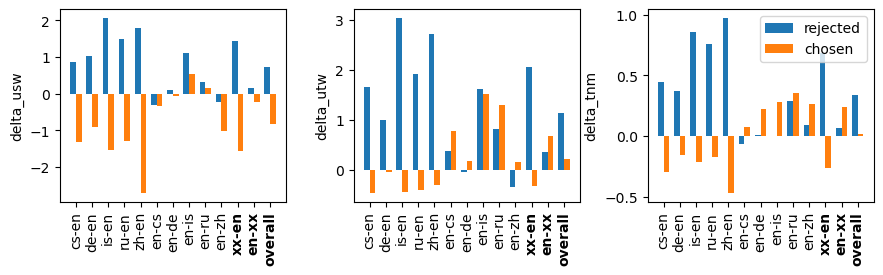

delta_usw           delta_utw           delta_tnm          
         rejected    chosen  rejected    chosen  rejected    chosen
lp                                                                 
cs-en    0.854005 -1.312068  1.650075 -0.464996  0.445276 -0.295041
de-en    1.016035 -0.906200  0.990597 -0.055132  0.369999 -0.156672
is-en    2.072952 -1.547265  3.036468 -0.445829  0.855239 -0.217637
ru-en    1.497062 -1.307685  1.915949 -0.403438  0.754828 -0.170764
zh-en    1.792601 -2.711917  2.702661 -0.318043  0.974175 -0.467772
en-cs   -0.305300 -0.351602  0.362799  0.766402 -0.065290  0.071922
en-de    0.091799 -0.071138 -0.051721  0.167399  0.009679  0.223930
en-is    1.101734  0.530646  1.607026  1.502659 -0.003037  0.278621
en-ru    0.319854  0.152314  0.808991  1.292127  0.290750  0.355534
en-zh   -0.219715 -1.016679 -0.341425  0.148718  0.093584  0.266715
xx-en    1.446531 -1.557027  2.059150 -0.337488  0.679903 -0.261577
en-xx    0.152222 -0.219500  0.360093  0.668202  0.062791  0.240383
overall  0.737815 -0.824646  1.128809  0.213191  0.341995  0.013278

In [445]:
do_eval(pref_data, ['delta_usw', 'delta_utw', 'delta_tnm'], lps, comp_systems, display_mode='plot')
do_eval(pref_data, ['delta_usw', 'delta_utw', 'delta_tnm'], lps, comp_systems, display_mode='df')

# Sandbox

## Evaluation data

In [62]:
with open('../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_greedy.pkl', 'rb') as f:
    kiwi_un_greedy = pickle.load(f)
with open('../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/xcomet_greedy.pkl', 'rb') as f:
    xcomet_un_greedy = pickle.load(f)
kiwi_xcomet_un_greedy = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_un_greedy, xcomet_un_greedy)]

with open('../data/evaluation/wmt22-23-test/ALMA-13B-R/kiwi_greedy.pkl', 'rb') as f:
    kiwi_al_greedy = pickle.load(f)
with open('../data/evaluation/wmt22-23-test/ALMA-13B-R/xcomet_greedy.pkl', 'rb') as f:
    xcomet_al_greedy = pickle.load(f)
kiwi_xcomet_al_greedy = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_al_greedy, xcomet_al_greedy)]

In [100]:
num_candidates = 5
temperature = 0.4

with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_N{num_candidates}_t{temperature}_p0.6.pkl', 'rb') as f:
    kiwi_nbest = pickle.load(f)
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/xcomet_N{num_candidates}_t{temperature}_p0.6.pkl', 'rb') as f:
    xcomet_nbest = pickle.load(f)
kiwi_xcomet_nbest = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_nbest, xcomet_nbest)]
kiwi_xcomet_nbest = [max(kiwi_xcomet_nbest[i * num_candidates : (i+1) * num_candidates]) for i in range(int(len(kiwi_xcomet_nbest) / num_candidates))]

In [101]:
np.mean(kiwi_xcomet_nbest), np.mean(kiwi_xcomet_al_greedy)

(0.8587255897396937, 0.857275124940245)

In [45]:
# Nbest decoding
num_candidates = 5
temperature = 0.4

# Load and compute scores
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_N{num_candidates}_t{temperature}_p0.6.pkl', 'rb') as f:
    kiwi_N = pickle.load(f)
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/xcomet_N{num_candidates}_t{temperature}_p0.6.pkl', 'rb') as f:
    xcomet_N = pickle.load(f)
kiwi_xcomet_N = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_N, xcomet_N)]

# Load hypotheses
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/hypotheses_N{num_candidates}_t{temperature}_p0.6.txt', 'r') as f:
    hypotheses = [hyp.replace('\\n', '\n') for hyp in f.read().split('\n')]

# Decode
hypotheses_nbest = []
xcomet_nbest = []
kiwi_nbest = []
kiwi_xcomet_nbest = []
for i in range(int(len(hypotheses) / num_candidates)):
    hyps = hypotheses[i * num_candidates : (i+1) * num_candidates]
    kx = kiwi_xcomet_N[i * num_candidates : (i+1) * num_candidates]
    k = kiwi_N[i * num_candidates : (i+1) * num_candidates]
    x = xcomet_N[i * num_candidates : (i+1) * num_candidates]
    sc_argmax = np.argmax(kx)
    hypotheses_nbest.append(hyps[sc_argmax])
    kiwi_nbest.append(k[sc_argmax])
    xcomet_nbest.append(x[sc_argmax])
    kiwi_xcomet_nbest.append(kx[sc_argmax])

# Save
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/hypotheses_nbest_N{num_candidates}_t{temperature}_p0.6.txt', 'w') as f:
    f.write('\n'.join([hyp.replace('\n', '\\n') for hyp in hypotheses_nbest]))

with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/xcomet_nbest_N{num_candidates}_t{temperature}_p0.6.pkl', 'wb') as f:
    pickle.dump(xcomet_nbest, f)

with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_nbest_N{num_candidates}_t{temperature}_p0.6.pkl', 'wb') as f:
    pickle.dump(kiwi_nbest, f)

with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_xcomet_nbest_N{num_candidates}_t{temperature}_p0.6.pkl', 'wb') as f:
    pickle.dump(kiwi_xcomet_nbest, f)

In [3]:
with open('../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/kiwi_greedy.pkl', 'rb') as f:
    kiwi_alma_un = pickle.load(f)
with open('../data/evaluation/wmt22-23-test/ALMA-13B-LoRA-Pre-CPO/xcomet_greedy.pkl', 'rb') as f:
    xcomet_alma_un = pickle.load(f)
kiwi_xcomet_alma_un = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_alma_un, xcomet_alma_un)]
np.mean(kiwi_alma_un), np.mean(xcomet_alma_un), np.mean(kiwi_xcomet_alma_un)

(0.7772493544160065, 0.8813197391447078, 0.8292845467803572)

In [4]:
with open('../data/evaluation/wmt22-23-test/ALMA-13B-R-Replica/kiwi_greedy.pkl', 'rb') as f:
    kiwi_alma_r_rep = pickle.load(f)
with open('../data/evaluation/wmt22-23-test/ALMA-13B-R-Replica/xcomet_greedy.pkl', 'rb') as f:
    xcomet_alma_r_rep = pickle.load(f)
kiwi_xcomet_alma_r_rep = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_alma_r_rep, xcomet_alma_r_rep)]
np.mean(kiwi_alma_r_rep), np.mean(xcomet_alma_r_rep), np.mean(kiwi_xcomet_alma_r_rep)

(0.8028964122215703, 0.8982762813480503, 0.8505863467848103)

In [23]:
hp = 'lr2e-3-e1'

with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-SFT-Pref-{hp}/kiwi_greedy.pkl', 'rb') as f:
    kiwi_alma_sft = pickle.load(f)
with open(f'../data/evaluation/wmt22-23-test/ALMA-13B-SFT-Pref-{hp}/xcomet_greedy.pkl', 'rb') as f:
    xcomet_alma_sft = pickle.load(f)
kiwi_xcomet_alma_sft = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_alma_sft, xcomet_alma_sft)]
np.mean(kiwi_alma_sft), np.mean(xcomet_alma_sft), np.mean(kiwi_xcomet_alma_sft)

(0.7836693907867949, 0.8895864247496632, 0.836627907768229)

In [15]:
with open('../data/evaluation/wmt22-23-test/ALMA-13B-R-No-Ext/kiwi_greedy.pkl', 'rb') as f:
    kiwi_no_ext = pickle.load(f)
with open('../data/evaluation/wmt22-23-test/ALMA-13B-R-No-Ext/xcomet_greedy.pkl', 'rb') as f:
    xcomet_no_ext = pickle.load(f)
kiwi_xcomet_no_ext = [(kiwi + xcomet) / 2 for kiwi, xcomet in zip(kiwi_no_ext, xcomet_no_ext)]
np.mean(kiwi_no_ext), np.mean(xcomet_no_ext), np.mean(kiwi_xcomet_no_ext)

(0.8002609696699394, 0.8950217533699202, 0.8476413615199297)

## Preference data

TODO: IMPLEM PROPERTIES

In [83]:
# Load preference data
lps = ['cs-en', 'de-en', 'is-en', 'ru-en', 'zh-en', 'en-cs', 'en-de', 'en-is', 'en-ru', 'en-zh']
xx_langs = set(lang for lp in lps for lang in set(lp.split('-')) if lang != 'en')
pref_data = pd.DataFrame() # pd.DataFrame(columns=['lp', 'src_lang', 'tgt_lang', 'src', 'alma', 'chosen', 'chosen_sys', 'alma_kiwi_xcomet', 'chosen_kiwi_xcomet'])
row = 0

for xx in xx_langs:
    if f'{xx}-en' in lps or f'en-{xx}' in lps:
        dataset_lp = load_dataset('haoranxu/ALMA-R-Preference', f'{xx}-en')['train']['translation']
        
        for ex in tqdm(dataset_lp, desc=f'{xx}-en'):        
            if 'required_directions' in ex and ex['required_directions'] != '':
                pairs = [tuple(ex['required_directions'].split('-'))]
            else:
                pairs = [(xx, 'en'), ('en', xx)]
            pairs = [lp for lp in pairs if f'{lp[0]}-{lp[1]}' in lps]

            for src_lang, tgt_lang in pairs:
                pref_data.loc[row, 'lp'] = f'{src_lang}-{tgt_lang}'
                pref_data.loc[row, 'src_lang'] = src_lang
                pref_data.loc[row, 'tgt_lang'] = tgt_lang
                pref_data.loc[row, 'src'] = ex[src_lang]

                if 'Delta' in ex and ex['Delta'] != 0:
                    if ex['Delta'] > 0:
                        chosen_sys, rejected_sys = 'gpt4', 'alma'
                    else:
                        chosen_sys, rejected_sys = 'alma', 'gpt4'
                else:
                    cdts_dict = {'alma': ex[f'alma_{tgt_lang}_kiwi_xcomet'], 'gpt4': ex[f'gpt4_{tgt_lang}_kiwi_xcomet'], 'ref': ex[f'ref_{tgt_lang}_kiwi_xcomet']}
                    chosen_sys = max(cdts_dict, key=cdts_dict.get)
                    rejected_sys = min(cdts_dict, key=cdts_dict.get)
                
                pref_data.loc[row, 'mt_alma'] = ex[f'alma_{tgt_lang}']  
                pref_data.loc[row, 'mt_rejected'] = ex[f'{rejected_sys}_'*(rejected_sys!='ref') + tgt_lang]
                pref_data.loc[row, 'mt_chosen'] = ex[f'{chosen_sys}_'*(chosen_sys!='ref') + tgt_lang]

                pref_data.loc[row, 'sys_rejected'] = rejected_sys
                pref_data.loc[row, 'sys_chosen'] = chosen_sys

                pref_data.loc[row, 'kiwi_xcomet_alma'] = ex[f'alma_{tgt_lang}_kiwi_xcomet']
                pref_data.loc[row, 'kiwi_xcomet_rejected'] = ex[f'{rejected_sys}_{tgt_lang}_kiwi_xcomet']
                pref_data.loc[row, 'kiwi_xcomet_chosen'] = ex[f'{chosen_sys}_{tgt_lang}_kiwi_xcomet']
                
                row += 1

is-en: 100%|██████████| 2009/2009 [00:17<00:00, 111.62it/s]


In [91]:
get_lengths(pref_data, mode='char', systems=['alma', 'rejected', 'chosen'])

In [92]:
get_lengths(pref_data, mode='word', systems=['alma', 'rejected', 'chosen'])

In [103]:
pref_data

,lp,src_lang,tgt_lang,src,mt_alma,mt_rejected,mt_chosen,sys_rejected,sys_chosen,kiwi_xcomet_alma,kiwi_xcomet_rejected,kiwi_xcomet_chosen,num_char_alma,num_char_rejected,num_char_chosen,num_words_alma,num_words_rejected,num_words_chosen
0,ru-en,ru,en,В понедельник ученые из Медицинской школы Стэн...,"On Monday, researchers at Stanford University'...","On Monday, scientists from the Stanford Univer...","On Monday, researchers at Stanford University'...",ref,alma,0.891410,0.810386,0.891410,235,264,235,44,49,44
1,en-ru,en,ru,"On Monday, scientists from the Stanford Univer...",В понедельник ученые из Школы медицины Стэнфор...,В понедельник учёные из Медицинской школы Стэн...,В понедельник ученые из Школы медицины Стэнфор...,gpt4,alma,0.947331,0.934558,0.947331,306,316,306,42,44,42
2,ru-en,ru,en,"Ведущие исследователи утверждают, что он может...",Leading researchers say it could help detect c...,Lead researchers say this may bring early dete...,Leading researchers claim that it can help in ...,ref,gpt4,0.843333,0.823999,0.928145,218,229,251,38,40,46
3,en-ru,en,ru,Lead researchers say this may bring early dete...,"Основные исследователи говорят, что это может ...","Основные исследователи говорят, что это может ...","Ведущие исследователи говорят, что это может п...",alma,gpt4,0.870960,0.870960,0.978656,277,277,276,50,50,49
4,ru-en,ru,en,Приблизительно в 9:30 по местному времени (02:...,"At approximately 9:30 local time (02:30 UTC), ...",The JAS 39C Gripen crashed onto a runway at ar...,At around 9:30 local time (02:30 UTC) a JAS 39...,ref,gpt4,0.926376,0.861010,0.927372,148,137,143,33,30,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22197,en-is,en,is,"Suits are standard business attire, and cowork...",Skyrtur eru hefðbundin viðskiptafatnaður og sa...,Skyrtur eru hefðbundin viðskiptafatnaður og sa...,Jakkaföt eru hefðbundinn viðskiptafatnaður og ...,alma,ref,0.773612,0.773612,0.970139,113,113,106,14,14,14
22198,is-en,is,en,"Samlyndi á vinnustað er lykilatriði, áhersla s...","Workplace harmony is key, with a focus on grou...","Workplace harmony is key, emphasis should be p...","Workplace harmony is crucial, emphasizing grou...",gpt4,ref,0.980246,0.975426,0.982561,86,121,103,16,20,14
22199,en-is,en,is,"Workplace harmony is crucial, emphasizing grou...","Vinna í sátt og samlyndi er mikilvæg, þar sem ...","Samlyndi á vinnustað er afar mikilvægt, þar se...","Samlyndi á vinnustað er lykilatriði, áhersla s...",gpt4,ref,0.975342,0.963236,0.979800,99,111,110,19,20,19
22200,is-en,is,en,Starfsmenn verða oft að fá samþykki yfirmanns ...,Employees are often required to get approval f...,Workers must often get their superiors' approv...,Employees are often required to get approval f...,ref,alma,0.974140,0.969508,0.974140,141,150,141,23,24,23


In [102]:
pref_data[pref_data.sys_chosen == 'alma'].iloc[:,-6:].mean()

num_char_alma         114.865252
num_char_rejected     116.875929
num_char_chosen       114.865252
num_words_alma         24.613191
num_words_rejected     24.713340
num_words_chosen       24.613191
dtype: float64

In [73]:
# Chosen systems
pref_data.sys_chosen.value_counts() / pref_data.shape[0]

sys_chosen
gpt4    0.429556
alma    0.333258
ref     0.237186
Name: count, dtype: float64

In [74]:
pref_data.sys_rejected.value_counts() / pref_data.shape[0]

sys_rejected
ref     0.438564
alma    0.331772
gpt4    0.229664
Name: count, dtype: float64

In [77]:
# Character len
pref_data['len_alma'] = [len(x) for x in pref_data.mt_alma]
pref_data['len_chosen'] = [len(x) for x in pref_data.mt_chosen]
pref_data['len_rejected'] = [len(x) for x in pref_data.mt_rejected]

In [78]:
pref_data.iloc[:,-3:].mean()

len_alma        114.316233
len_chosen      118.614449
len_rejected    116.125799
dtype: float64

In [81]:
pref_data[pref_data.sys_chosen == 'ref'].iloc[:,-3:].mean()

len_alma        112.181732
len_chosen      117.389670
len_rejected    114.055830
dtype: float64

In [62]:
### TODO: other properties

# Old

## Punctuation insertion

Takeway: more punctuation into English

In [ ]:
punct_symbols = ['.', ',', '!', '?', ':', ';']
count_punct_symbols(eval_df, punct_symbols)
compute_deltas(eval_df, ['num_punct'])

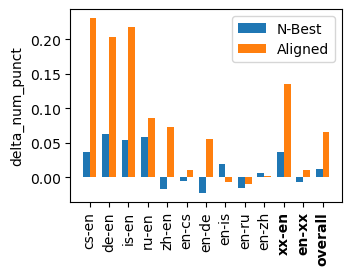

delta_num_punct          
                  nbest        al
lp                               
cs-en          0.036093  0.231423
de-en          0.062554  0.204170
is-en          0.054381  0.217523
ru-en          0.058371  0.086594
zh-en         -0.017460  0.073016
en-cs         -0.004734  0.010651
en-de         -0.022439  0.055610
en-is          0.018809 -0.006270
en-ru         -0.015704 -0.009422
en-zh          0.006652  0.001478
xx-en          0.036882  0.134744
en-xx         -0.006857  0.010035
overall        0.012557  0.065389

In [ ]:
do_eval(eval_df, ['delta_num_punct'], lps, display_mode='plot')
do_eval(eval_df, ['delta_num_punct'], lps, display_mode='df')

In [ ]:
extract_examples_gen(eval_df, ppty='num_punct', min_abs_delta_ppty=2, num_ex=10)

**********
Example 1:
**********

   lp  xcomet_un  xcomet_nbest  xcomet_al  num_punct_un  num_punct_nbest  num_punct_al  delta_num_punct_nbest  delta_num_punct_al
cs-en  95.063168     96.957052  97.759914             2                2             8                      0                   6

===> src:
Pohřešovaná Češka podle ní v neděli 28 . listopadu okolo 19 : 45 odešla z práce a zamířila domů do
čtvrti Camberwell .

===> ref:
She said that the missing Czech woman left work on Sunday 28 November at around 19 : 45 and headed
home to the Camberwell area .

===> mt_un:
The missing Czech woman left work at around 7 : 45pm on Sunday 28 November and headed home to Camberwell
.

===> mt_nbest:
The missing Czech woman left work at around 7.45pm on Sunday 28 November and headed home to Camberwell .

===> mt_al:
The missing Czech woman , according to her , left work around 7 : 45 p . m . on
Sunday , November 28 , and headed home to the Camberwell district .

**********
Example 2:
**********


## Name and number recognition

Takeways:
* Names: no clear message + names can be extracted in different ways (e.g., "Apple" != "The Apple Company")
* Numbers: increasing trend but largely biased by number naming issues (e.g., "the 1980s" != "the 80s", "12,000 != 12000")

In [1066]:
extract_named_entities(eval_df)
extract_numbers(eval_df)
compute_f1(eval_df, ['names', 'numbers'])

Aligned: 100%|██████████| 10751/10751 [00:23<00:00, 462.39it/s]


In [1068]:
compute_deltas(eval_df, ['names', 'numbers'])

In [ ]:
do_eval(eval_df, ['delta_names_F1', 'delta_numbers_F1'], lps, display_mode='plot')
do_eval(eval_df, ['delta_names_F1', 'delta_numbers_F1'], lps, display_mode='df')

In [710]:
df_ex = eval_df.iloc[(eval_df['delta_numbers_F1_al'] - eval_df['delta_numbers_F1_nbest']).values.argsort()[::-1]]
df_ex = df_ex[['ref', 'mt_un', 'mt_nbest', 'mt_al', 'numbers_ref', 'numbers_un', 'numbers_nbest', 'numbers_al', 'delta_numbers_F1_nbest', 'delta_numbers_F1_al']].dropna()

In [720]:
k = 3
print(df_ex.iloc[k]['ref'])
print(df_ex.iloc[k]['mt_un'])
print(df_ex.iloc[k]['mt_nbest'])
print(df_ex.iloc[k]['mt_al'])

挪威统计局的数据显示，外国人分散在奥斯陆的各个区，奥斯陆最南端的圣德勒诺斯特兰德区有超过 14000 名移民在那里登记。
统计局的数据显示，外国人分布在整个城市的各个区域，而奥斯陆最南的一个区域索尔特纳德斯特兰 (Søndre Nordstrand) 就有 14,000 名移民登记在册。
统计局的数据显示，外国人分布在整个城市的各个区域，而奥斯陆最南的一个区域索尔特纳（Søndre Nordstrand）就有14,000多名移民登记在册。
挪威统计局的数据显示，外国人分布在奥斯陆市各个区域，而奥斯陆市最南的一个行政区索尔德纳尔斯特兰（Søndre Nordstrand），已有超过14000名移民登记在册。


In [717]:
df_ex

,ref,mt_un,mt_nbest,mt_al,numbers_ref,numbers_un,numbers_nbest,numbers_al,delta_numbers_F1_nbest,delta_numbers_F1_al
27178,"However, the government wants to do more than ...",But the government is not only planning to adj...,But the government is not only planning to adj...,But the government is not only planning to tig...,"{200, 1}",{1200},{1200},"{200, 1}",0.0,100.000000
9208,«Если мы говорим о числе российских компаний в...,«Если мы говорим о количестве российских компа...,«Если мы говорим о количестве российских компа...,""" Если говорить о количестве российских компан...",{4000},{4},{4},{4000},0.0,100.000000
3010,"Almost 1,200 hector were covered by the meter-...",Almost 1200 hectares were covered by a layer o...,Nearly 1200 hectares were covered by a meter-t...,"Nearly 1,200 hectares were covered by a meter-...","{200, 1}",{1200},{1200},"{200, 1}",0.0,100.000000
33320,挪威统计局的数据显示，外国人分散在奥斯陆的各个区，奥斯陆最南端的圣德勒诺斯特兰德区有超过 1...,统计局的数据显示，外国人分布在整个城市的各个区域，而奥斯陆最南的一个区域索尔特纳德斯特兰 (...,统计局的数据显示，外国人分布在整个城市的各个区域，而奥斯陆最南的一个区域索尔特纳（Søndr...,挪威统计局的数据显示，外国人分布在奥斯陆市各个区域，而奥斯陆市最南的一个行政区索尔德纳尔斯特...,{14000},"{14, 000}","{14, 000}",{14000},0.0,100.000000
33319,Gamle Oslo 也有大量的移民人口，有 17631 人从另一个国家移居到这里。,"旧奥斯陆也有一个较大的移民人口，共有 17,631 人来自另一个国家。","旧奥斯陆也有一个较大的移民人口，共有 17,631 人来自其他国家。",在旧奥斯陆，移民人口也占有相当大的比例，共有17631人从其他国家迁入该地。,{17631},"{17, 631}","{17, 631}",{17631},0.0,100.000000
...,...,...,...,...,...,...,...,...,...,...
15706,1. Our store supports seven-day return and exc...,1.This store supports a 7-day return and excha...,1. This store supports a 7-day return and exch...,This store offers a 7-day return and exchange ...,{1},"{7, 1}","{7, 1}",{7},0.0,-66.666667
17241,I myself have helped 59 Internet customers to ...,I have helped 59 Internet customers to purchas...,I have helped 59 Internet customers to purchas...,I have helped 59 Internet customers myself to ...,"{2000, 3000, 59}","{2000, 3000, 59}","{2000, 3000, 59}","{000, 2, 3, 59}",0.0,-71.428571
3899,Stávající technologie prověřuje pouze určité o...,"Technologie, která je v současnosti k dispozic...","Technologie, která je v současnosti k dispozic...",Současná technologie dokáže detekovat pouze ur...,{19},{19},{19},{2},0.0,-100.000000
660,"According to available information, he ended u...","According to available information, he stole a...","According to available information, he stole a...","According to available information, he ultimat...",{330},{329},{330},{329},100.0,0.000000
